# Определение аномалий с помощью IsolationForest

Процент аномалий, подсчитанный по переменной Class: 0.17 %.

## Загрузим данные
И импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

df_train = pd.read_csv(r'.\creditcard_train.csv')
df_test = pd.read_csv(r'.\creditcard_test.csv')

X_train, y_train = df_train.drop('Class', axis=1), df_train['Class']
X_test, y_test = df_test.drop('Class', axis=1), df_test['Class']

In [2]:
from sklearn.ensemble import IsolationForest
model = IsolationForest(n_estimators=100, contamination=0.0017,
                        max_features=1.0, bootstrap=True)
model.fit(X_train)

isolation_outliers = model.predict(X_train)
isolation_outliers = np.array([1 if label == -1 else 0 for label in isolation_outliers])

In [3]:
# Вывод информации по аномальным транзакциям и выбросам
print('Количество выбросов в выборке: {}'.format(sum(isolation_outliers)))
print('Процент выбросов в выборке: {:.2%}'.format(sum(isolation_outliers)/len(X_train)))

Количество выбросов в выборке: 388
Процент выбросов в выборке: 0.17%


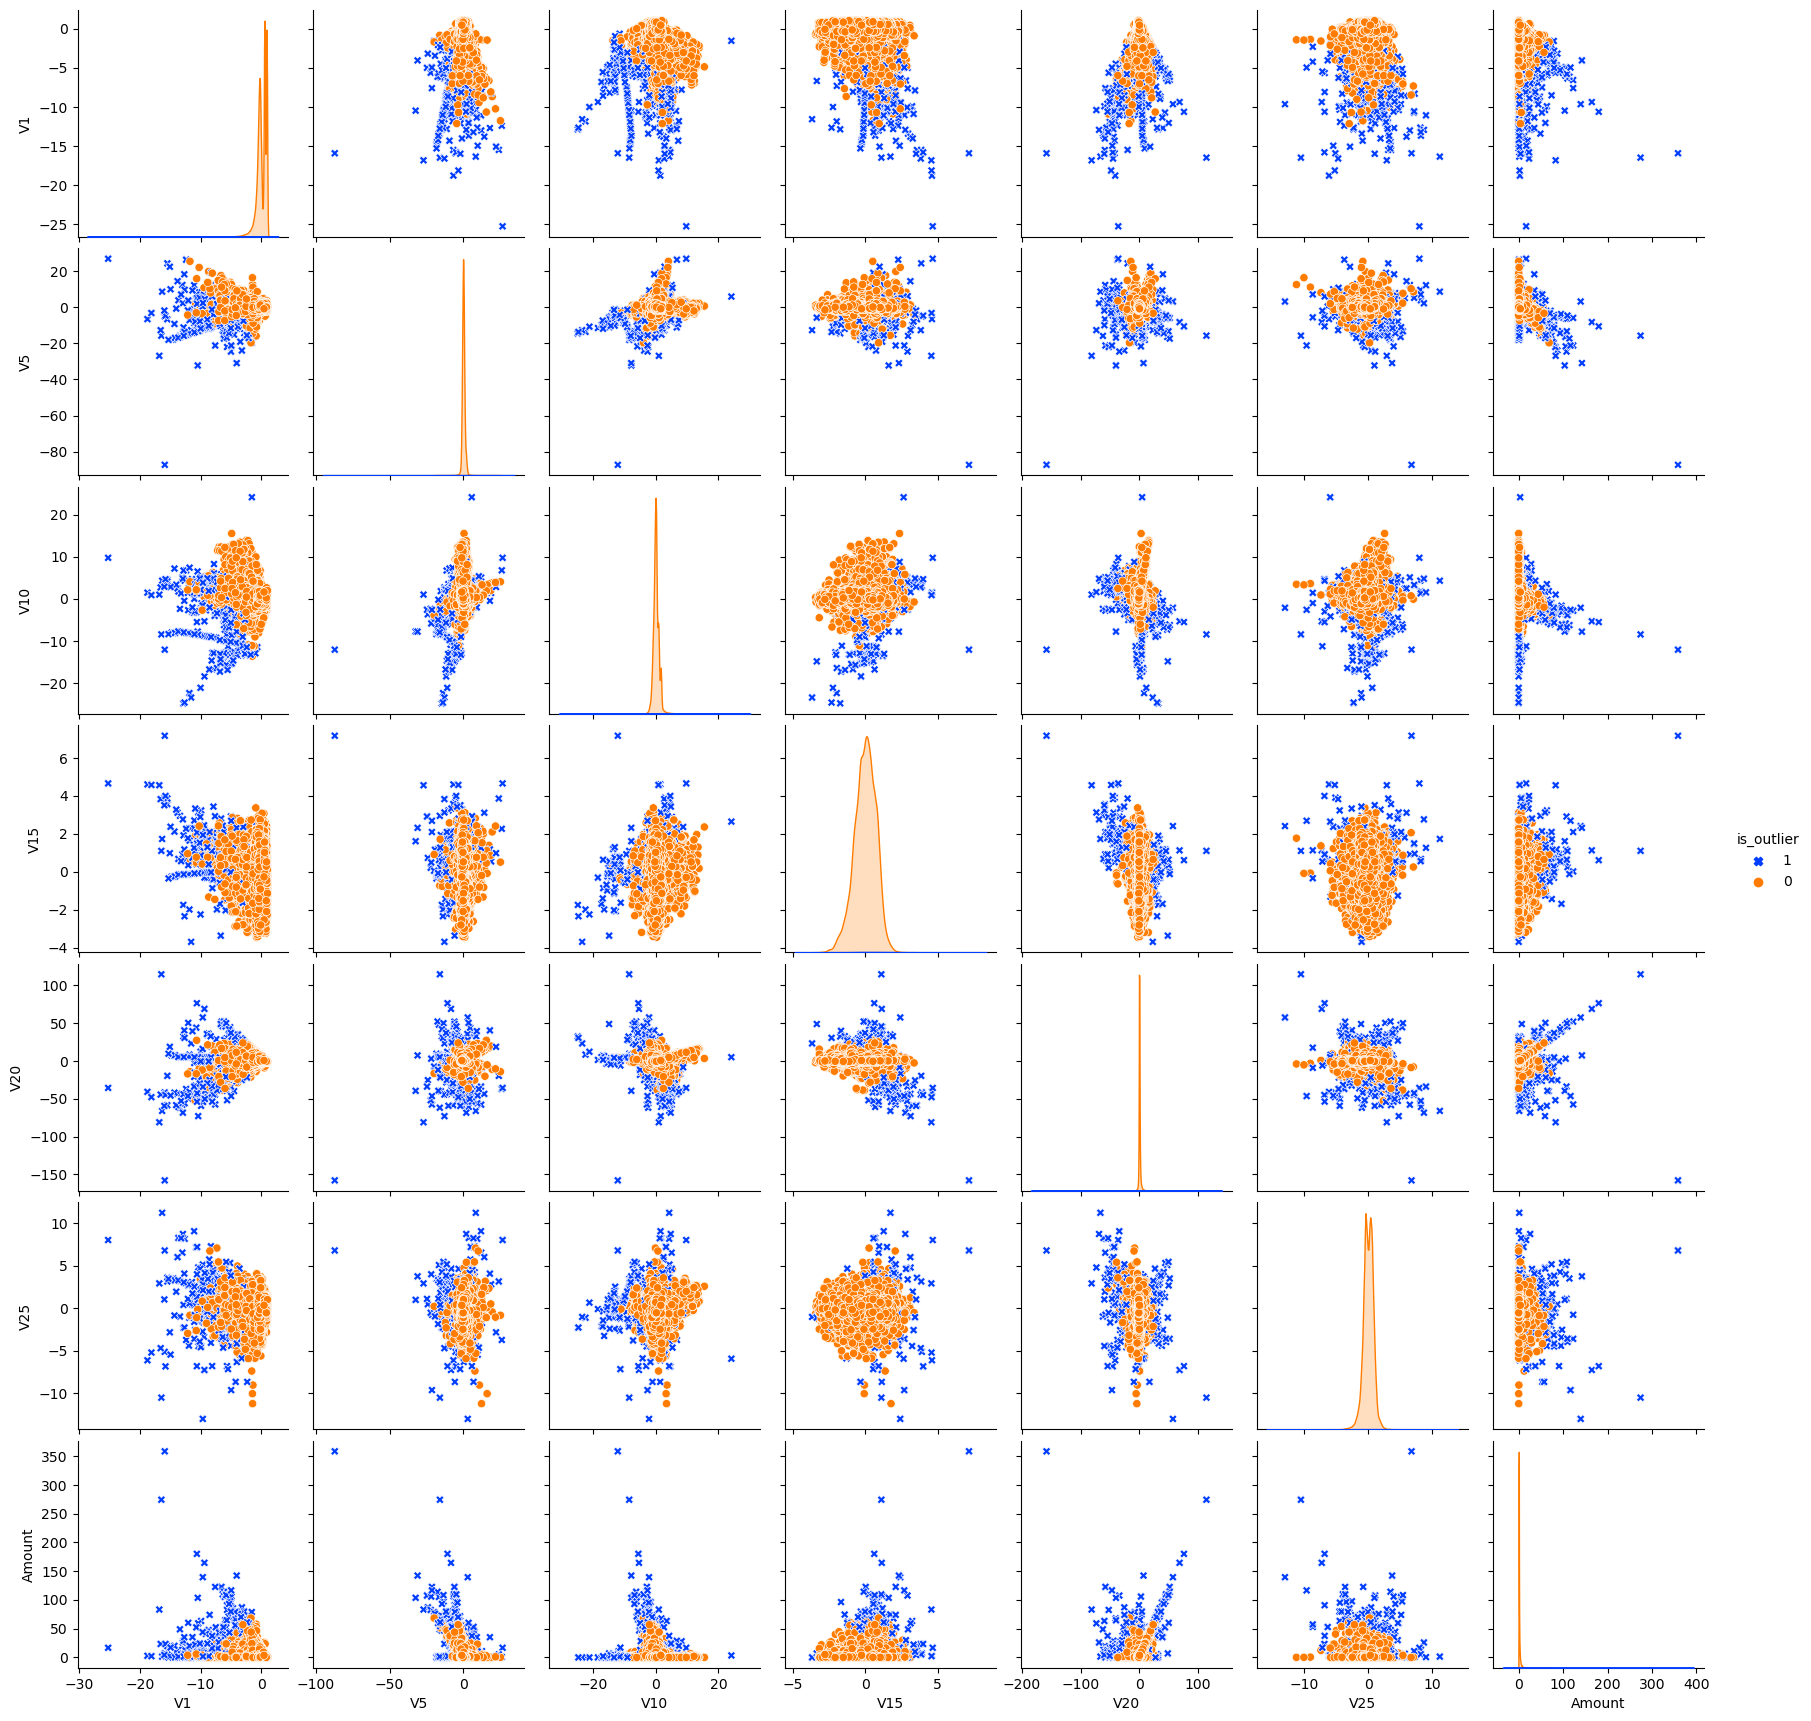

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_columns = ['V1', 'V5', 'V10', 'V15', 'V20', 'V25', 'Amount']

labeled_data = X_train.copy()
labeled_data['is_outlier'] = isolation_outliers

sns.pairplot(data=labeled_data, vars = selected_columns,
             hue='is_outlier', hue_order=[1, 0],
             markers=['o', 'X'],  palette='bright');

plt.savefig('IsolationForestPairplot.png')

## Протестируем на тестовой выборке

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred = np.array([1 if label == -1 else 0 for label in y_pred])

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = ['True 0', 'True 1'], columns = ['Predicted 0', 'Predicted 1'])
print('Confusion Matrix:\n')
print(df_cm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.24      0.26      0.25        98

    accuracy                           1.00     56962
   macro avg       0.62      0.63      0.62     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:

        Predicted 0  Predicted 1
True 0        56783           81
True 1           73           25


## Визуализация с UMAP

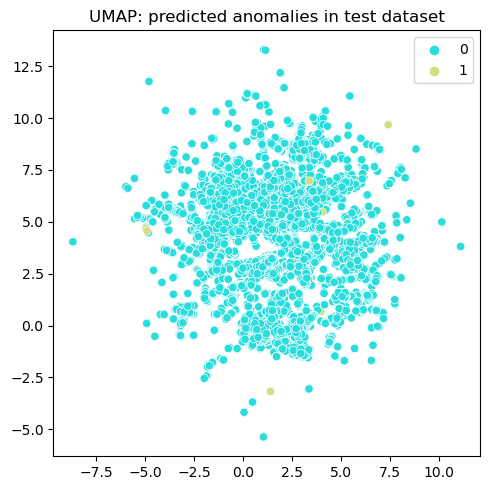

In [6]:
# !pip install umap-learn

import umap

# Manual settings:

n_components = 5 # Default 2
n_neighbors = 5 # Default 15
min_dist = 0.1 # Default 0.1

#

reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist) #, random_state=1) ← "Use no seed for parallelism"

# Processing with reduce dimensions
X_umap = reducer.fit_transform(X_test)

# Plot results
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=y_pred, palette='rainbow', ax=axs)
axs.set_title('UMAP: predicted anomalies in test dataset')
fig.get_figure().savefig('IsolationForestUMAPpredictedAnomaliesAtTest.png', dpi=120, bbox_inches='tight', pad_inches = 0.5)
plt.tight_layout()
plt.show()